In [1]:
# %pip install gymnasium
# %pip install lib-pybroker
# %pip install stable-baselines3

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost

        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))

        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance

    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}

    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]
        amount = int(self.initial_balance * action[1] / current_price)

        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)

        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio

        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()

        self.current_step += 1

        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False

        self.done = done

        info = {}
        return obs, reward, done, False,info


    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])

    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]

        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)

    def render_all(self):
        df = self.render_df.set_index('Date')
        fig, ax = plt.subplots(figsize=(18, 6))
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey')
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')

        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')

In [3]:
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')
import pandas as pd
from stable_baselines3 import PPO

In [4]:
yfinance = YFinance()
df = yfinance.query(['GOOG'], start_date='3/1/2021', end_date='1/1/2024')
df['date'] = pd.to_datetime(df['date']).dt.date
df

Loaded cached bar data.



,date,symbol,open,high,low,close,volume,adj_close
0,2021-03-01,GOOG,102.825996,104.325996,102.305000,104.075500,28090000,103.820534
1,2021-03-02,GOOG,103.809502,105.218498,103.563004,103.792000,22692000,103.537735
2,2021-03-03,GOOG,103.360497,104.425903,100.500000,101.335503,29684000,101.087250
3,2021-03-04,GOOG,101.168503,104.461998,101.013496,102.454498,42360000,102.203506
4,2021-03-05,GOOG,103.655998,105.905502,102.320747,105.427002,43904000,105.168724
...,...,...,...,...,...,...,...,...
710,2023-12-22,GOOG,142.130005,143.250000,142.054993,142.720001,18494700,142.370361
711,2023-12-26,GOOG,142.979996,143.945007,142.500000,142.820007,11170100,142.470123
712,2023-12-27,GOOG,142.830002,143.320007,141.050995,141.440002,17288400,141.093506
713,2023-12-28,GOOG,141.850006,142.270004,140.828003,141.279999,12192500,140.933899


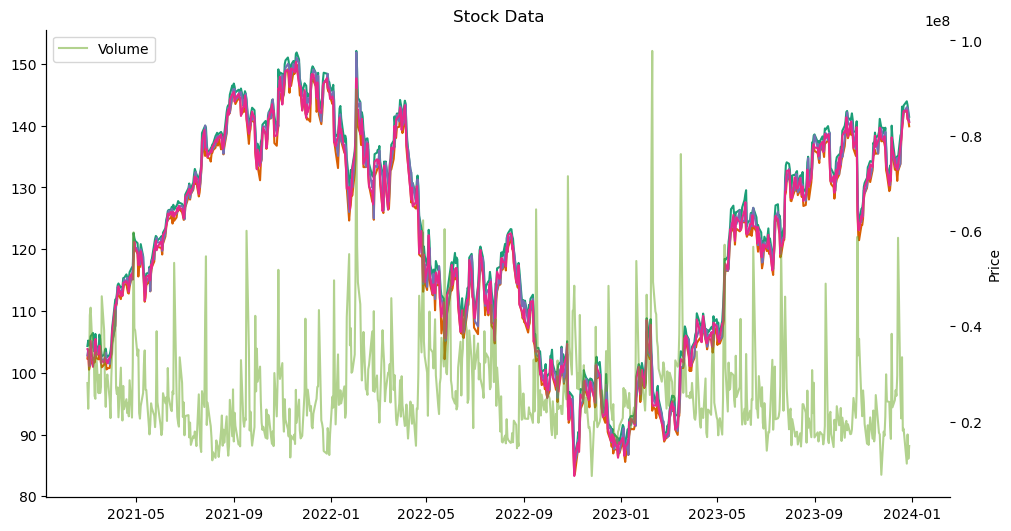

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['date']

    # Plot high, low, open, close on the primary y-axis
    plt.plot(xs, series['high'], label='High', color=palette[0])
    plt.plot(xs, series['low'], label='Low', color=palette[1])
    plt.plot(xs, series['open'], label='Open', color=palette[2])
    plt.plot(xs, series['adj_close'], label='Close', color=palette[3])

    # Create a secondary y-axis for volume
    ax2 = plt.twinx()
    ax2.plot(xs, series['volume'], label='Volume', color=palette[4], alpha=0.5)  # Adjust alpha for visibility
    ax2.set_ylabel('Volume')

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
plt.ylabel('Price')  # Label for primary y-axis
plt.title('Stock Data')  # Add a title
plt.legend(loc='upper left')  # Display legend
plt.show()  # Show the plot

In [6]:
env = StockTradingEnv(df, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

# model = PPO("MlpPolicy", env, verbose=0)
# model.learn(total_timesteps=100_000, progress_bar=True)
# model.save("ppo_aapl")

In [7]:
# Testing cell modification

yfinance = YFinance()
# Update date range to only fetch available data
df = yfinance.query(['GOOG'], start_date='1/1/2024', end_date='3/11/2024')
df['date'] = pd.to_datetime(df['date']).dt.date

# Validate data
if len(df) == 0:
    raise ValueError("No data available for specified date range")

env = StockTradingEnv(df, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

try:
    model = PPO.load("ppo_aapl", env=env)
    
    initial_balance = 100000
    portfolio_values = []
    actions_taken = []

    obs = env.reset()[0]
    done = False
    
    while not done:
        action, _state = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        portfolio_value = env.balance + env.stock_owned * env.stock_price_history[env.current_step]
        portfolio_values.append(portfolio_value)
        actions_taken.append(action[0])

    # Calculate metrics only if we have data
    if portfolio_values:
        final_return = (portfolio_values[-1] - initial_balance) / initial_balance * 100
        sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values) if np.std(portfolio_values) != 0 else 0

        print(f"Final Portfolio Value: ${portfolio_values[-1]:,.2f}")
        print(f"Return: {final_return:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        # Plot results
        plt.figure(figsize=(12,6))
        plt.plot(portfolio_values)
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Trading Steps')
        plt.ylabel('Portfolio Value ($)')
        plt.show()
    else:
        print("No trading data generated")
        
except Exception as e:
    print(f"Error during testing: {str(e)}")

Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:01 



Error during testing: 47
